In [1]:
# imports
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries which we'll use just
# to produce some visualizations of our training
from lib.utils import montage
from lib import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [55]:
import PIL.ImageGrab
from matplotlib.pyplot import imshow,subplots,plot
import seaborn as sns
%matplotlib inline

def print_img_from_clipboard():
    img = PIL.ImageGrab.grabclipboard()
    fig, ax = subplots(figsize=(90, 30))
    imshow(img, interpolation='nearest')

In [3]:
#import mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST',one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# we are doing clusteting task , so we don't need Validation and Test. So we better concatenate train,
#test,validation parts to get more train data

X_train = np.concatenate([mnist.train.images,mnist.validation.images,mnist.test.images])

In [5]:
#lets create a fuction that creates autoencoder
#first part of it is encoder. you we just need to create a subgraph that somehow reduces dimensions

def create_encoder(input_placeholder,deep_dimensions,non_linear=tf.nn.tanh):
    #input
    #input_placeholder = tf.placeholder that contains input placeholder
    #dimensions - dimension list a deep layers
    #non_linear = tf.nn.* non_linear function
    
    #output
    #endoder_output - tensor with encoded values
    #W_list - list of Ws of the encoder
    ##b_list = [] - list of bs of the encoder
    current_input = input_placeholder
    n_input = int(list(input_placeholder.get_shape())[1])
    
    #then lets reverse dimensions to be used by decoder
    reversed_deep_dimensions = deep_dimensions[::-1][1:]+[n_input]
    
    W_list = []
    #b_list = []
    #lets glue input placeholder to encoder  by  creating each enoder layer
    
    for layer_index,n_output in enumerate(deep_dimensions):
        #creating layer with specific name
        with tf.variable_scope('encoder/layer%i' % layer_index):
            #create weight matrix of the layer. it reduces dimension from n_input to n_output by using linear algebra
            with tf.name_scope('W'):
                W = tf.Variable(tf.random_normal(name='W',shape=[n_input,n_output],mean=0.0,stddev=0.02))
                #lets append every W to W_list end export it to be used in decoder
                W_list.append(W)
            #with tf.name_scope('b'):
            #    b = tf.Variable(tf.zeros(name='b',shape=[n_output]))
            #    b_list.append(b)
            with tf.name_scope('dot'):
                #sum_ = tf.add(tf.matmul(current_input,W),b)
                dot = tf.matmul(current_input,W)
            #and lets create a nonlinear transformation
            with tf.name_scope('non_linear'):
                non_linear_transformation = non_linear(dot)
            #and use this transformation and its column space as an input to the next layer
            current_input,n_input = non_linear_transformation,n_output
    #lets reverse produced W_list to be used by decoder
    W_list = W_list[::-1]
    #b_list = b_list[::-1]
    encoder_output = non_linear_transformation
    return encoder_output,W_list,reversed_deep_dimensions

In [57]:
#lets create a fuction that creates autoencoder
#first part of it is encoder. you we just need to create a subgraph that somehow reduces dimensions
def create_decoder(encoder_output,W_list,deep_dimensions,non_linear=tf.nn.tanh):
    #input
    #W_list - list of Ws of the encoder
    #encoder_output = tf.placeholder that contains encoder output
    #dimensions_T - reversed transposed dimensions list 
    #non_linear = tf.nn.* non_linear function
    
    #output
    #decoder output - tensor with decoded values
    
    current_input = encoder_output
    n_input = int(encoder_output.get_shape()[1])
    n_deep_dimentions = int(len(deep_dimensions))
    #lets glue encoder output to decoder  by  creating each decoder layer
   
    for layer_index,n_output in enumerate(deep_dimensions):
        #creating layer with specific name
        with tf.variable_scope('decoder/layer%i_T' % (n_deep_dimentions-layer_index-1)):
            #create weight matrix of the layer. it reduces dimension from n_input to n_output by using linear algebra
            with tf.name_scope('W_T'):
                #W_to_upload = tf.contrib.copy_graph.copy_variable_to_graph(W_list[layer_index][0],to_graph=tf.Graph().as_default())
                W = tf.transpose(W_list[layer_index])
                #lets append every W to W_list end export it to be used in decoder
            #with tf.name_scope('b'):
            #    b = b_list[layer_index]
            with tf.name_scope('dot'):
                #sum_ = tf.add(tf.matmul(current_input,W),b)
                dot = tf.matmul(current_input,W)
            #and lets create a nonlinear transformation
            with tf.name_scope('non_linear'):
                non_linear_transformation = non_linear(dot)
            #and use this transformation and its column space as an input to the next layer
            current_input,n_input = non_linear_transformation,n_output
    decoder_output = non_linear_transformation
    return decoder_output

In [58]:
#lets import iterate the batches to be used in train
def iterate_over_batches(input_array,batch_size=100):
    #input_values - np.array which is needed to be iterated
    #yeilds batched with size = batch_size
    total_values = len(list(input_array))
    #print(total_values)
    for index in range(int(total_values/batch_size)):
        start_index = index*batch_size
        end_index = start_index+batch_size
        yield input_array[start_index:end_index]
    if total_values%batch_size!=0.0:
        yield input_array[-int(total_values%batch_size):]

In [59]:
#lets create a fuction that runs the fucking training


def train_autoencoder(X_train,X,loss,decoder_output=None,optimizer=tf.train.AdamOptimizer,\
                                          learning_rate=1e-3,n_epochs = 10 ,\
                                         standartize=True,save=False,\
                                          log=False,gif=False,show_img=False
                                         ):
        #X_Train, - array train
        #X input placeholder of the graph
        #loss - loss which will be optimized
        
        #metric - target metric to calculate
        #tensor that - buddy that encodes than decodes
        #learning rate 
        #n_epochs
        #standartize - whether to substract mean
        #save - filename - if specified saves model to filename
        #log - filename - if specified will log the train to filename
        #gif - filename - if specified will create a fucking gif
        
        #we will substract mean if required
        if standartize:
            mean_value = np.mean(X_train,axis=0)
        else:
            mean_value = np.zeros(X_train.shape[1])
        
        #lets initialize values of the variables
        with tf.name_scope('Optimizer'):
            optimizer = optimizer(learning_rate=learning_rate).minimize(loss)
        
        init_op = tf.global_variables_initializer()
        #we will log loss and metric if requiored
       
        loss_sum = tf.scalar_summary('train_loss',loss)
        #metric_sum = tf.scalar_summary('train_accuracy',metric)
        summapy_op = tf.merge_summary([loss_sum])
        
        #we will save model if required
        if save:
            saver = tf.train.Saver()
        #store imgs in a list to create a gif
        if show_img or gif:
            test_examples = X_train[:25]
            test_images =montage(test_examples.reshape((-1, 28, 28)))
        
        if show_img or gif:
            imgs=[]
        #lets start the session
        with tf.Session() as sess:
            sess.run(init_op)
            #lets create a log writer if required and counter
            if log:
                writer = tf.train.SummaryWriter(log, graph=tf.get_default_graph())
                
                
            #lets start training
            for epoch in range(n_epochs):
                #over all the batches lets train
                for batch_xs in iterate_over_batches(X_train):
                    #lets just train if its too boring
                    
                    sess.run(optimizer, feed_dict={X: (batch_xs-mean_value)})
                if log:
                    
                    epoch_loss,train_sum = sess.run([loss,summapy_op], feed_dict={X:(X_train[:10000]-mean_value)})
                    writer.add_summary(train_sum,epoch)
                else:
                    epoch_loss = sess.run(loss, feed_dict={X:(X_train[:10000]-mean_value)})
                    
                print('epoch %i loss: %f' % (epoch,epoch_loss))
                if show_img or gif:
                    if decoder_output== None:
                        print('Provide decoder tensor to reconstruct the image')
                        return None
                    recon = sess.run(decoder_output, feed_dict={X: X_train[:25] - mean_value})
                    recon =np.clip((recon + mean_value).reshape((-1, 28, 28)), 0, 255)
                    img_i = montage(recon)
                    imgs.append(img_i)
                if show_img:
                    if epoch % show_img ==0:
                        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
                        axs[0].imshow(test_images)
                        axs[0].set_title('Original')
                        axs[1].imshow(img_i)
                        axs[1].set_title('Synthesis')
                        fig.canvas.draw()
                        plt.show()
            if save:
                saver.save(sess,save)
            if gif:
                x = [test_images]*(int(len(imgs)/2))+imgs
                gif.build_gif(x, saveto=gif) 
            if log:
                writer.close()

In [60]:
#here is X_train.shape
X_train.shape

(70000, 784)

In [61]:
#parameters
tf.reset_default_graph()


#lets specify hyperparamenets
deep_dimensions = [512,256,128,32]
non_linear=tf.nn.tanh

#lets finally build the fucking model
#lets create a encoder
with tf.name_scope('X_train'):
    X = tf.placeholder(tf.float32,shape=[None,784])
#lets build en encoder and then decoder
encoder_output,W_list,reversed_deep_dimensions = create_encoder(X,deep_dimensions,non_linear)
decoder_output = create_decoder(encoder_output,W_list,reversed_deep_dimensions)
#lets define a loss functions with will be optimized 
#with tf.name_scope('cross_entropy'):
#    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(X, decoder_output))
with tf.name_scope('MSE'):
    cost = tf.reduce_mean(tf.squared_difference(X,decoder_output),1)
    mean_squared_difference = tf.reduce_mean(cost)    



epoch 0 loss: 0.041972


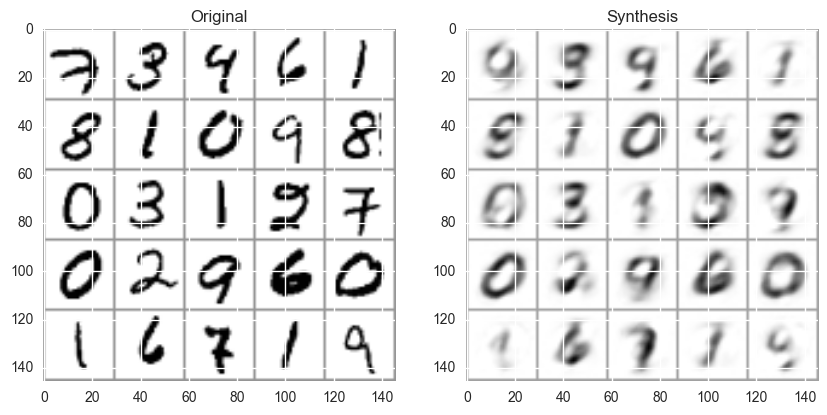

In [62]:
#ill train one time here just to save the graph
train_autoencoder(X_train,X,mean_squared_difference,decoder_output=decoder_output,optimizer=tf.train.AdamOptimizer,\
                                          learning_rate=1e-3,n_epochs = 1 ,\
                                         standartize=True,save=False,\
                                          log='log',gif=False,show_img=24
                                         )
#and it shows reconstructions after one epoch of 32 label encoder

In [63]:
!tensorboard --logdir=run1:log/ --port 6006

Starting TensorBoard b'39' on port 6006
(You can navigate to http://192.168.1.121:6006)
^CTraceback (most recent call last):
  File "/Users/narek/anaconda3/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/Users/narek/anaconda3/lib/python3.5/site-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/Users/narek/anaconda3/lib/python3.5/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/Users/narek/anaconda3/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt



In [64]:
#here is the how the graph is looking  

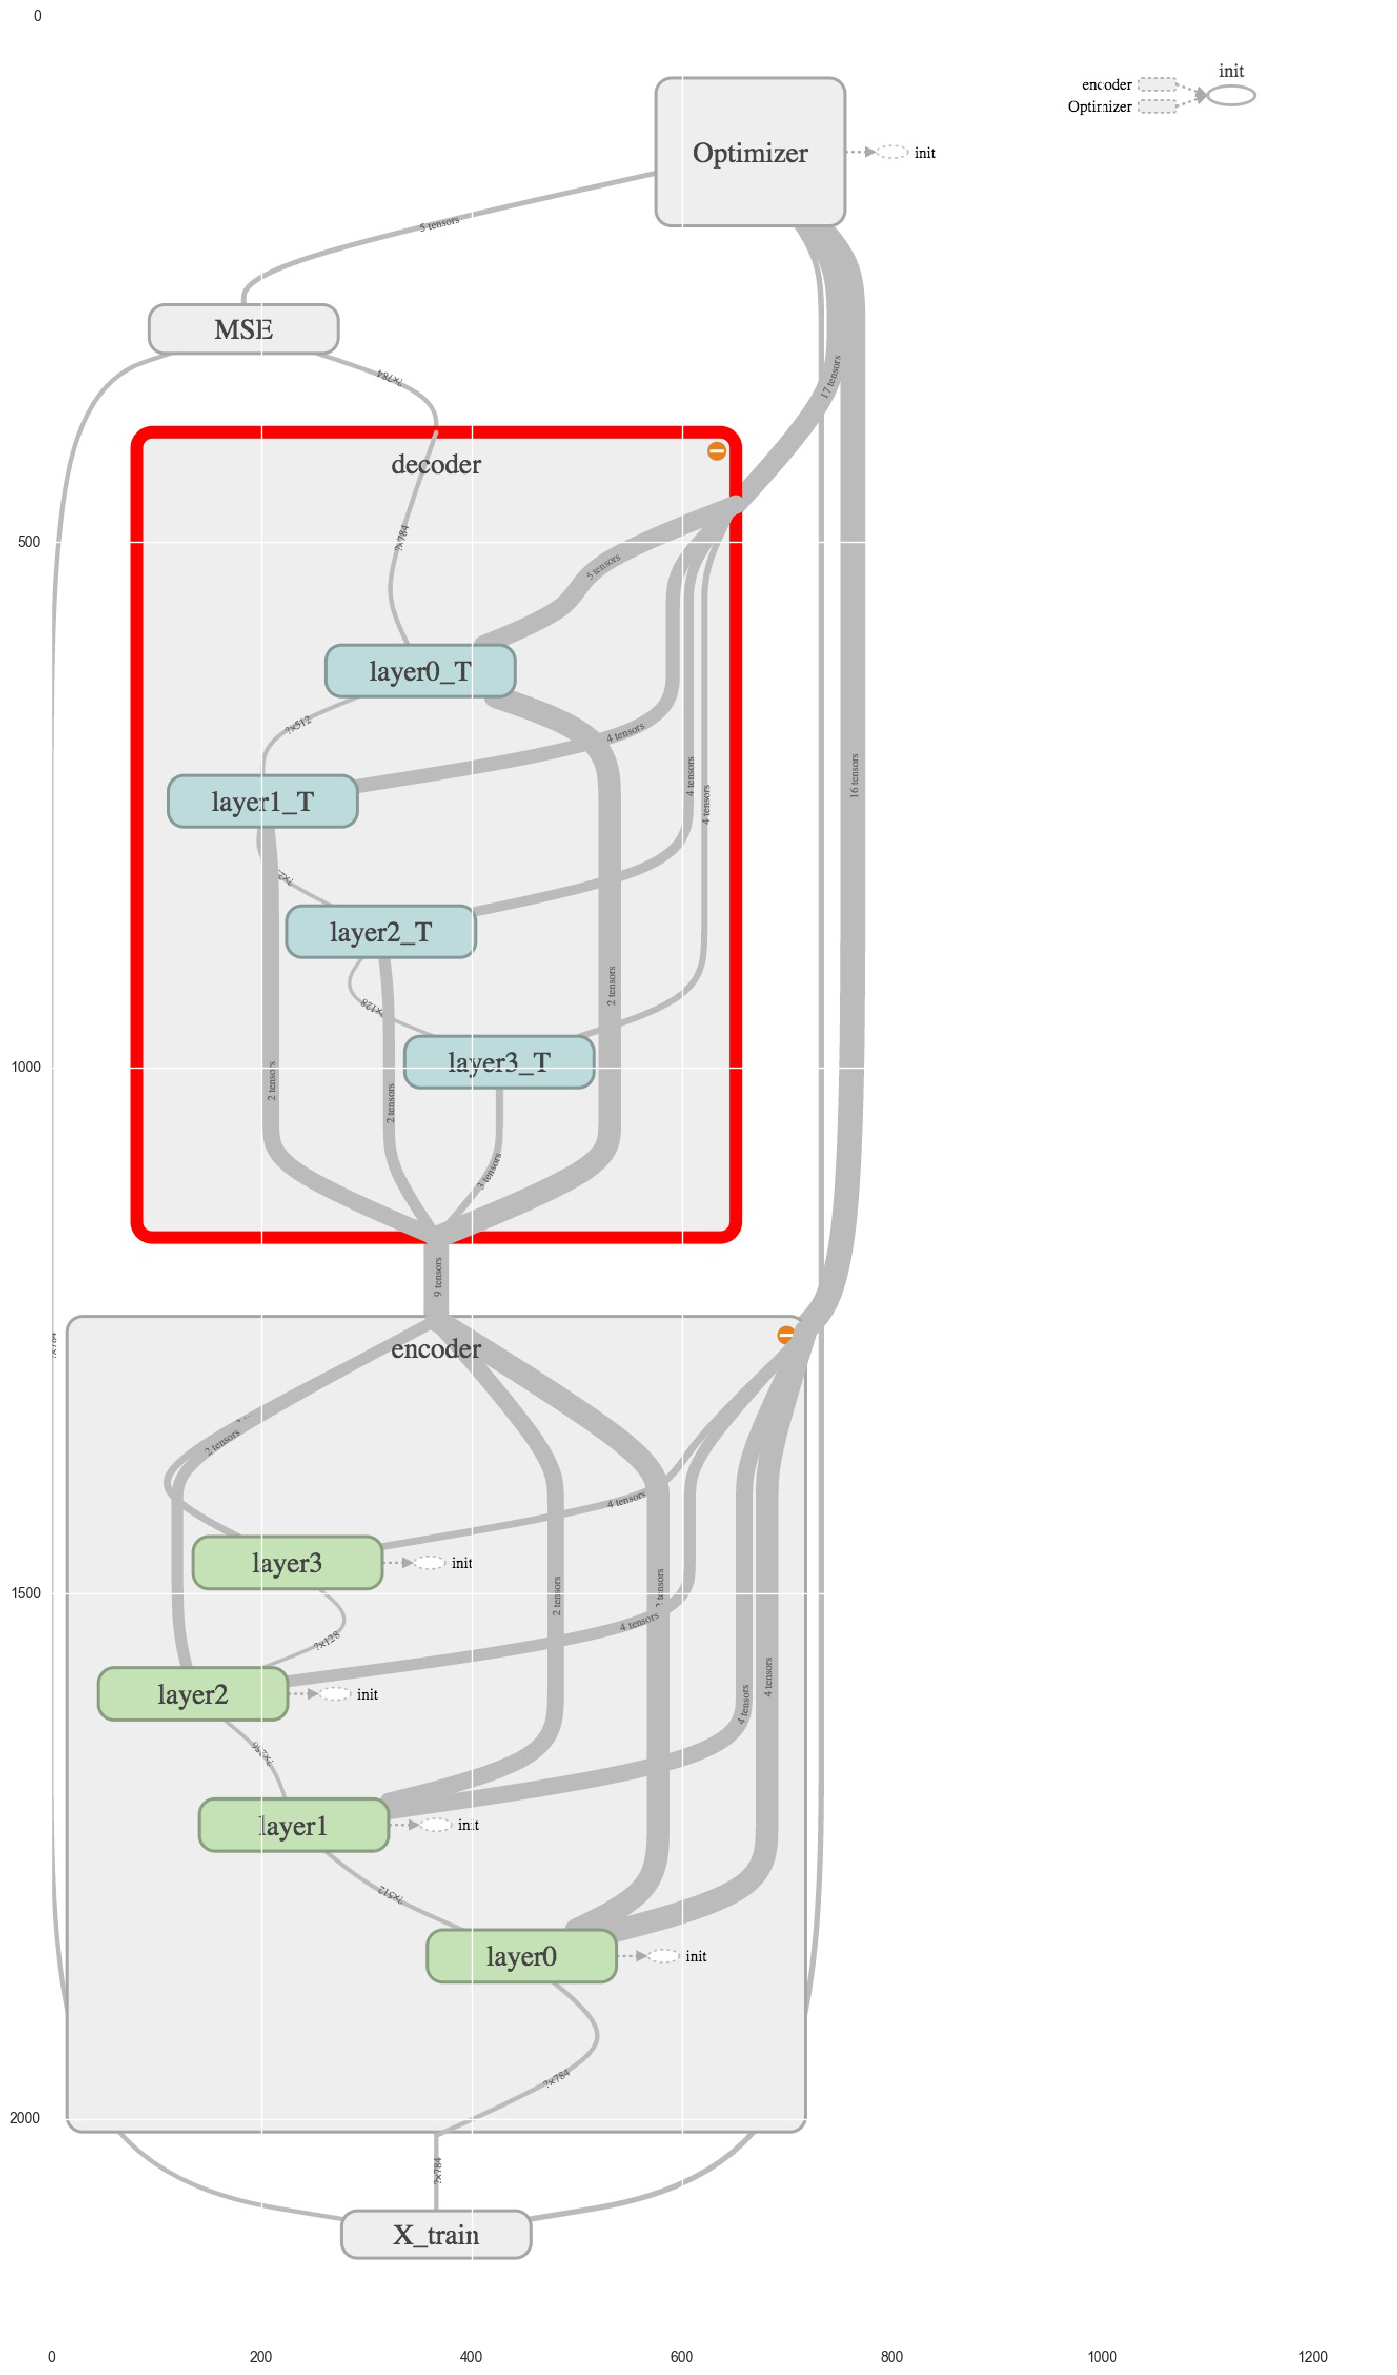

In [65]:
print_img_from_clipboard()

In [67]:
#I trained it more on p4.x1 engine on AWS and got couple more results
#here is output from 32 label encodeing

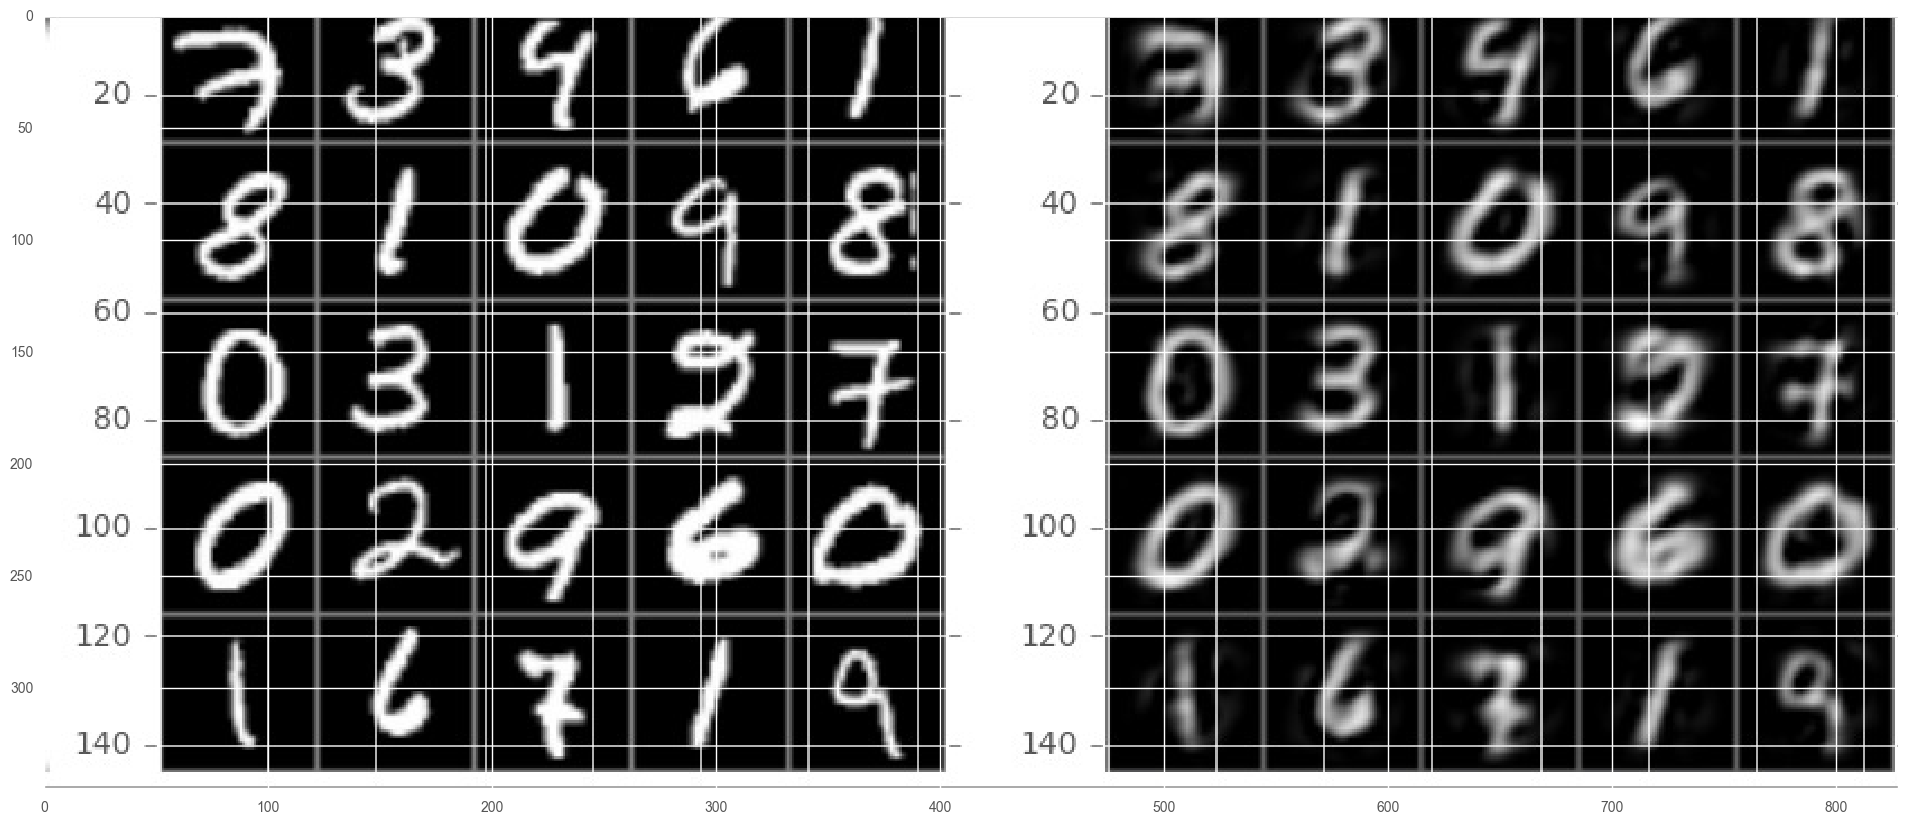

In [210]:
print_img_from_clipboard()

In [68]:
#here how loss function look 32 label encodeing, results doen't change much after epoch 17

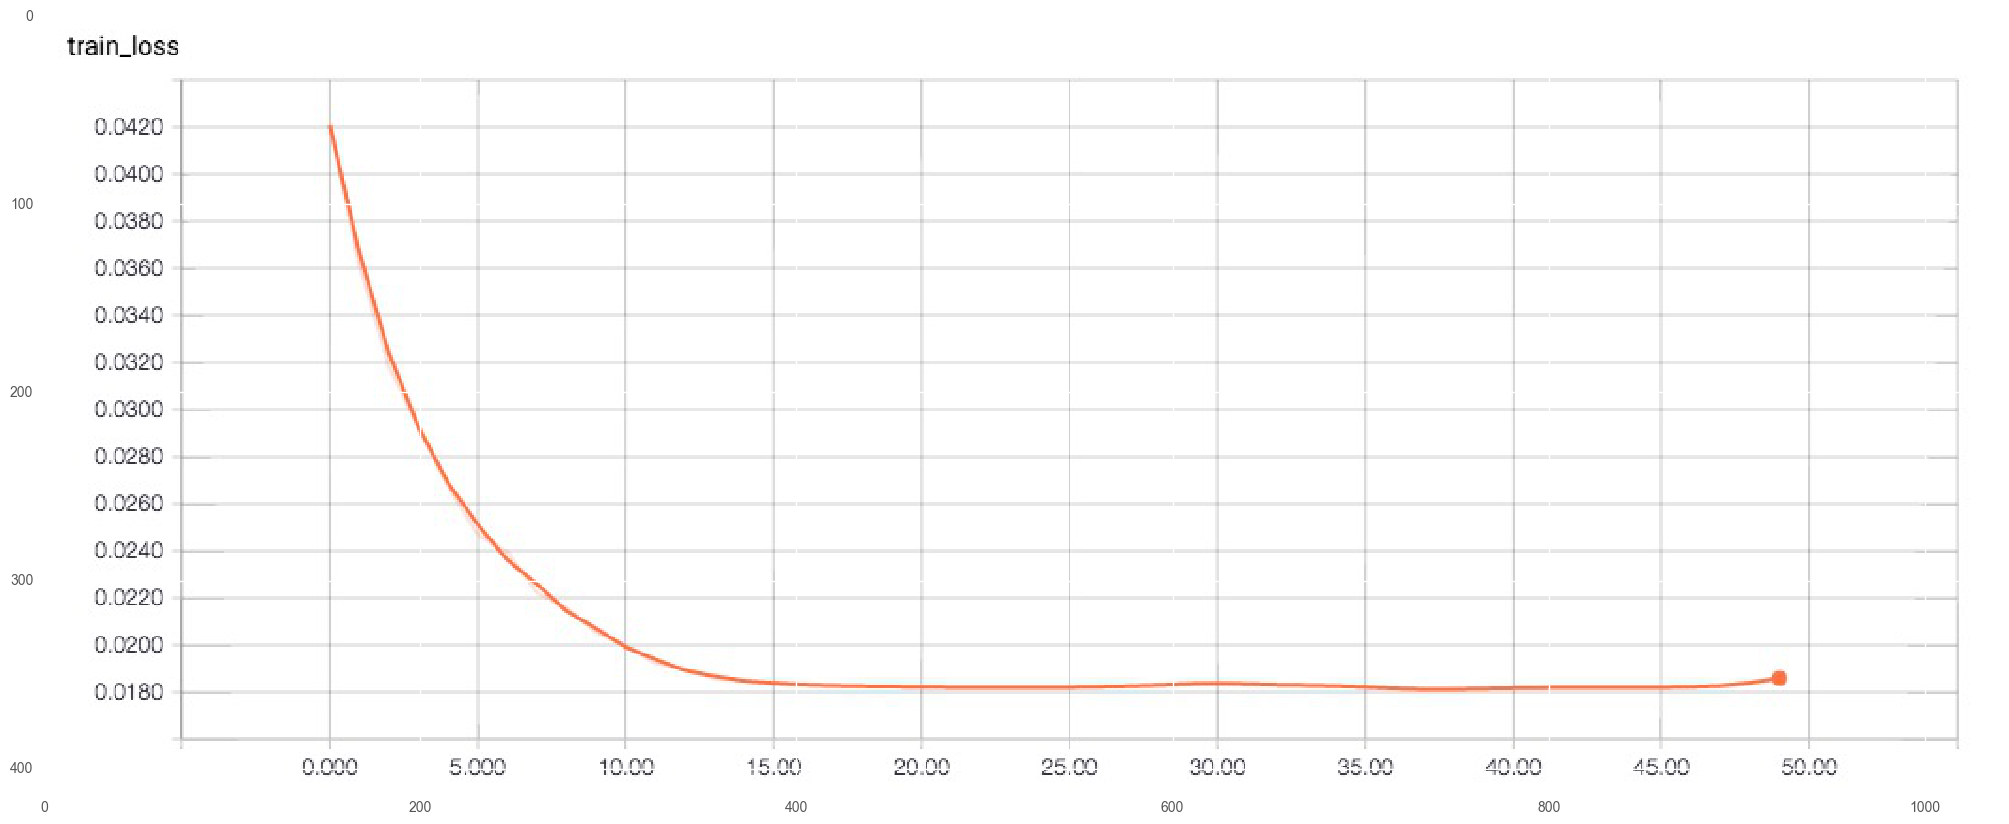

In [209]:
print_img_from_clipboard()

In [216]:
#16 labels
#here is output from 16 label encodeing much blurier

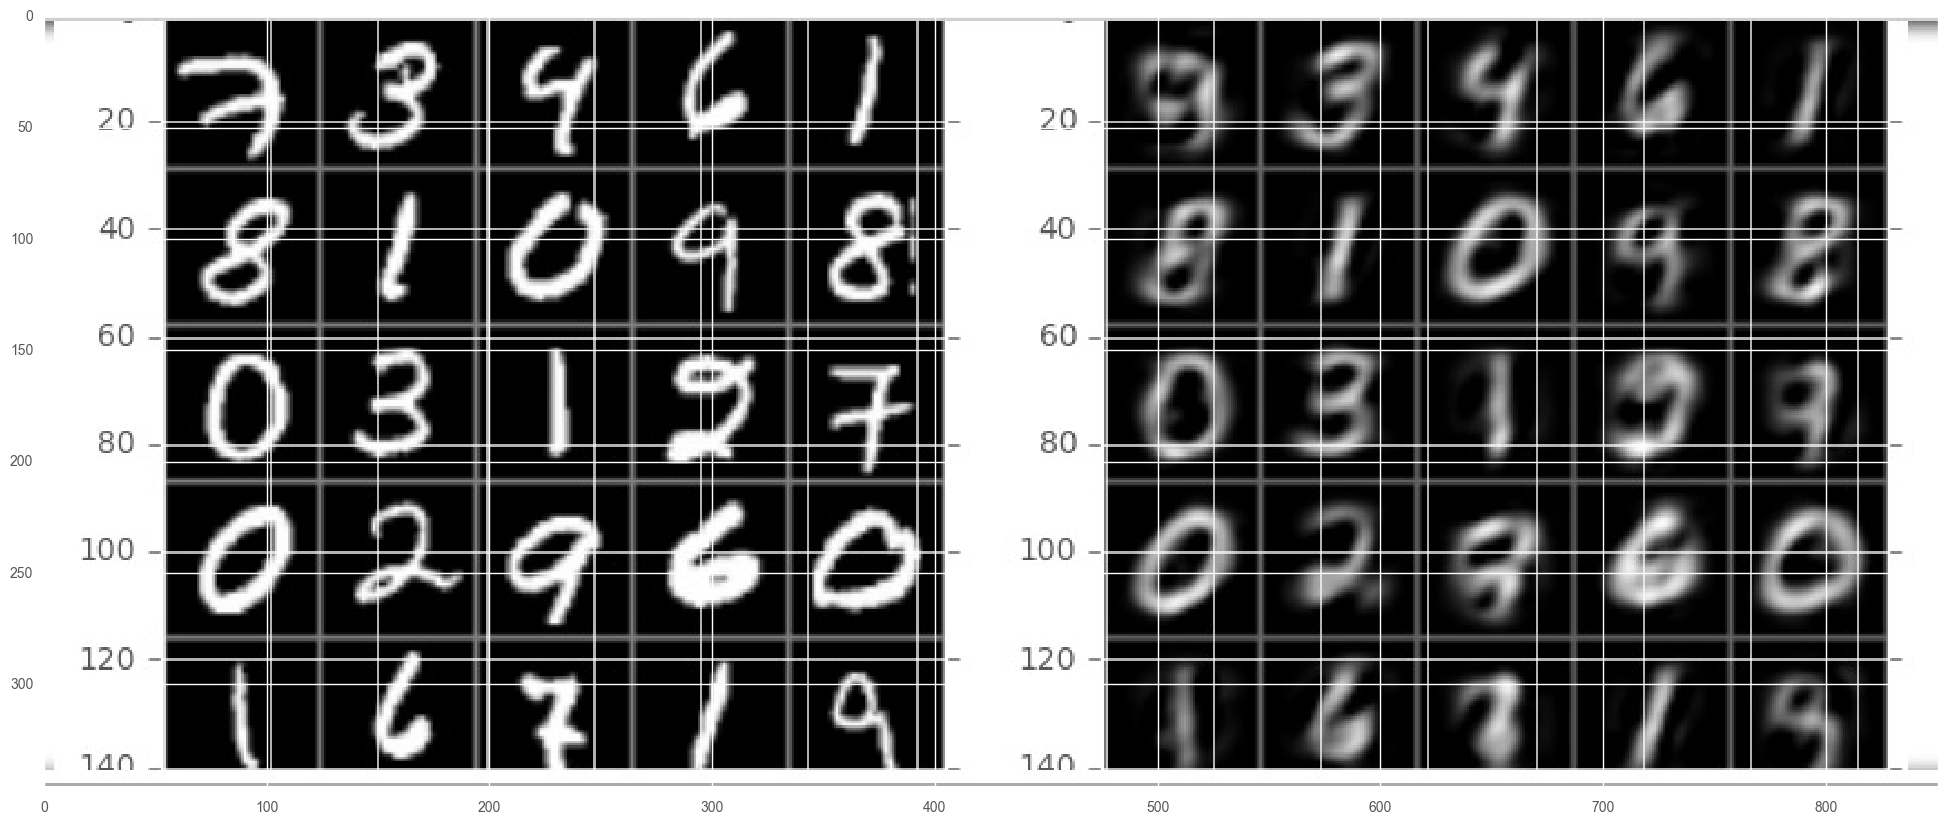

In [211]:
print_img_from_clipboard()

In [69]:
#training limit was riched faster (epoch 15)
#and will go faster and faster and we wouldn't get better results when we train with smaller final label dimension

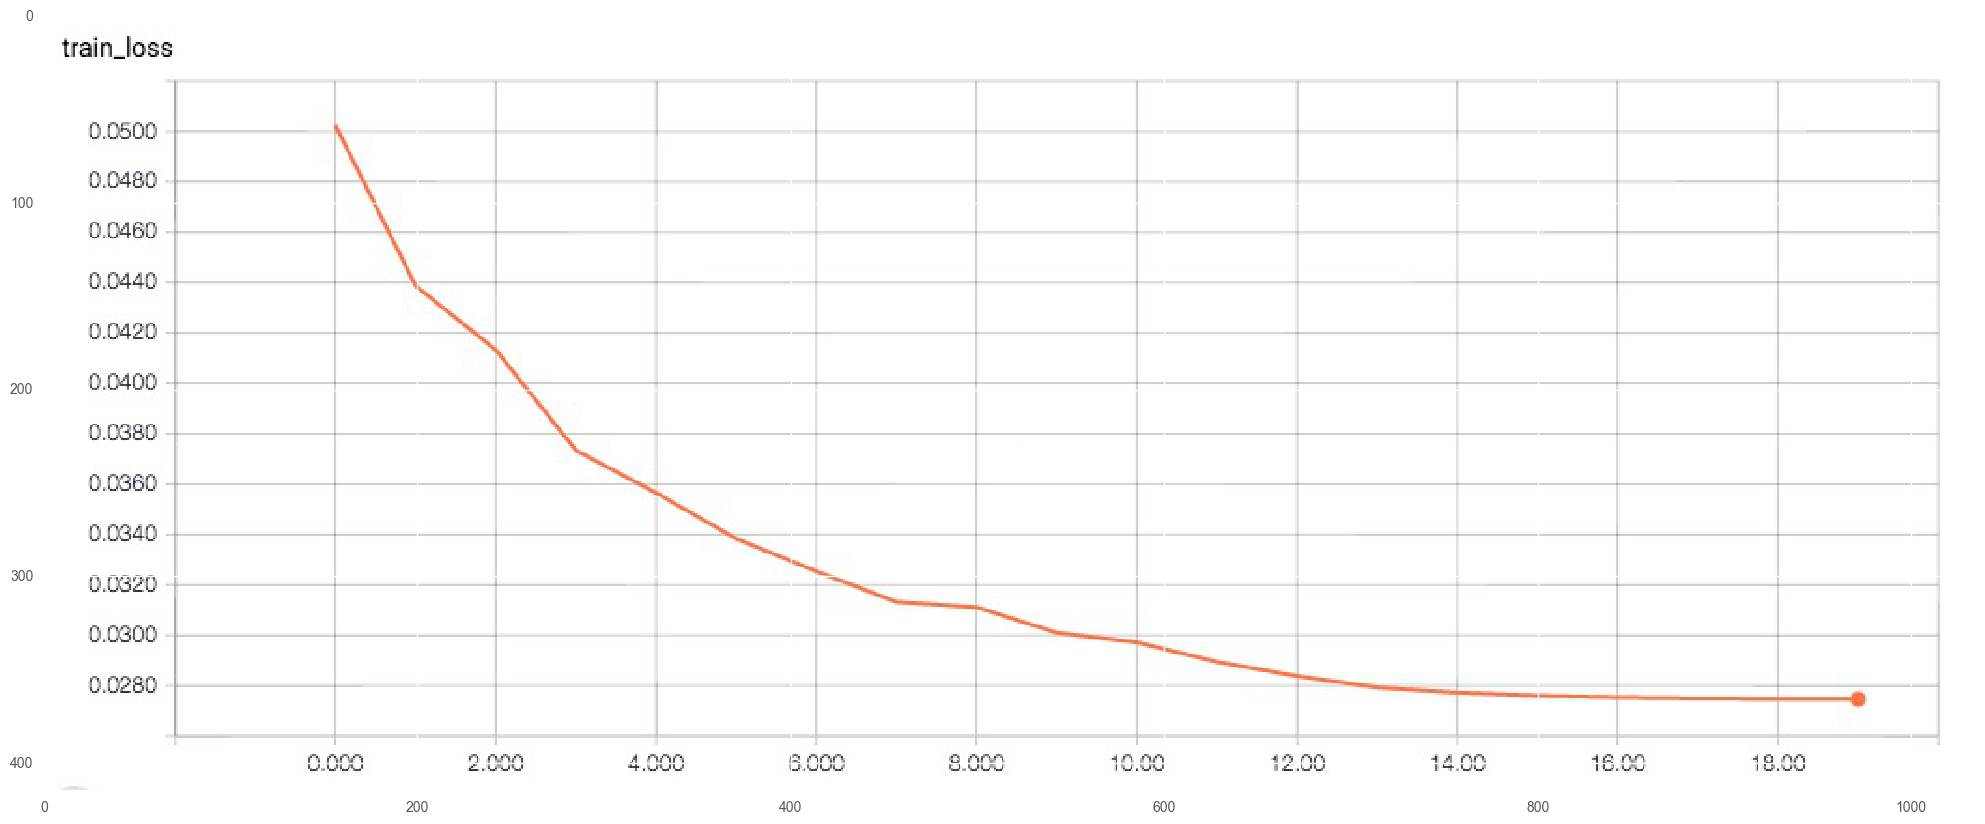

In [212]:
print_img_from_clipboard()

In [217]:
#here is output for 8 labels. more blurring

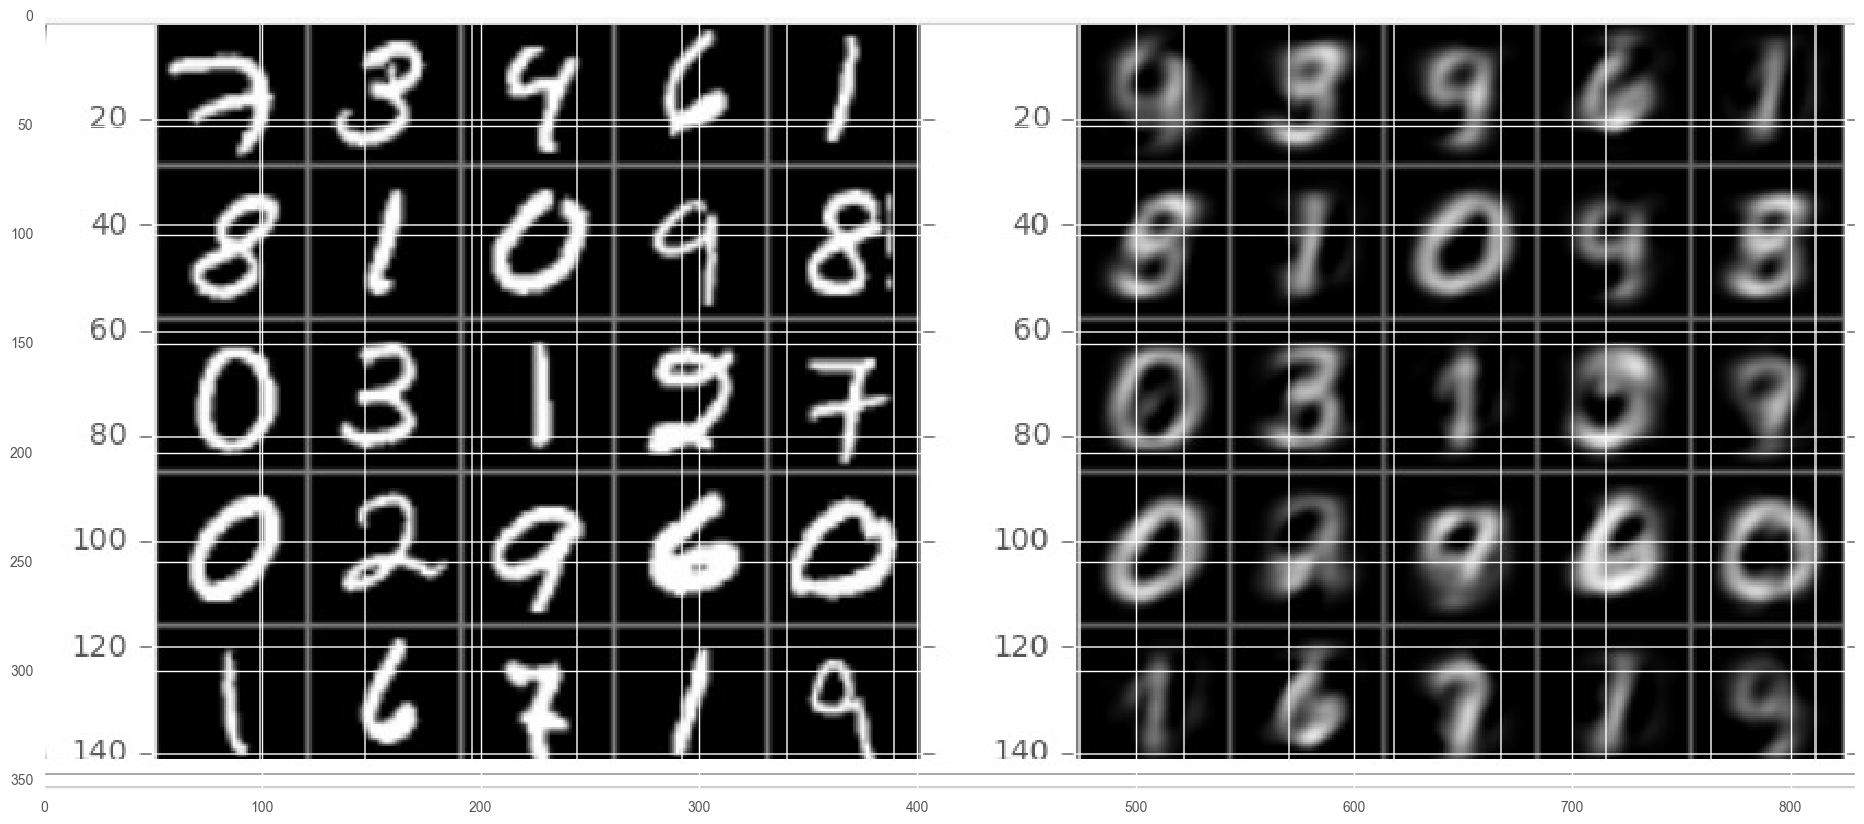

In [213]:
print_img_from_clipboard()

In [70]:
#4 labels gives us just a mean of the image with the same approach

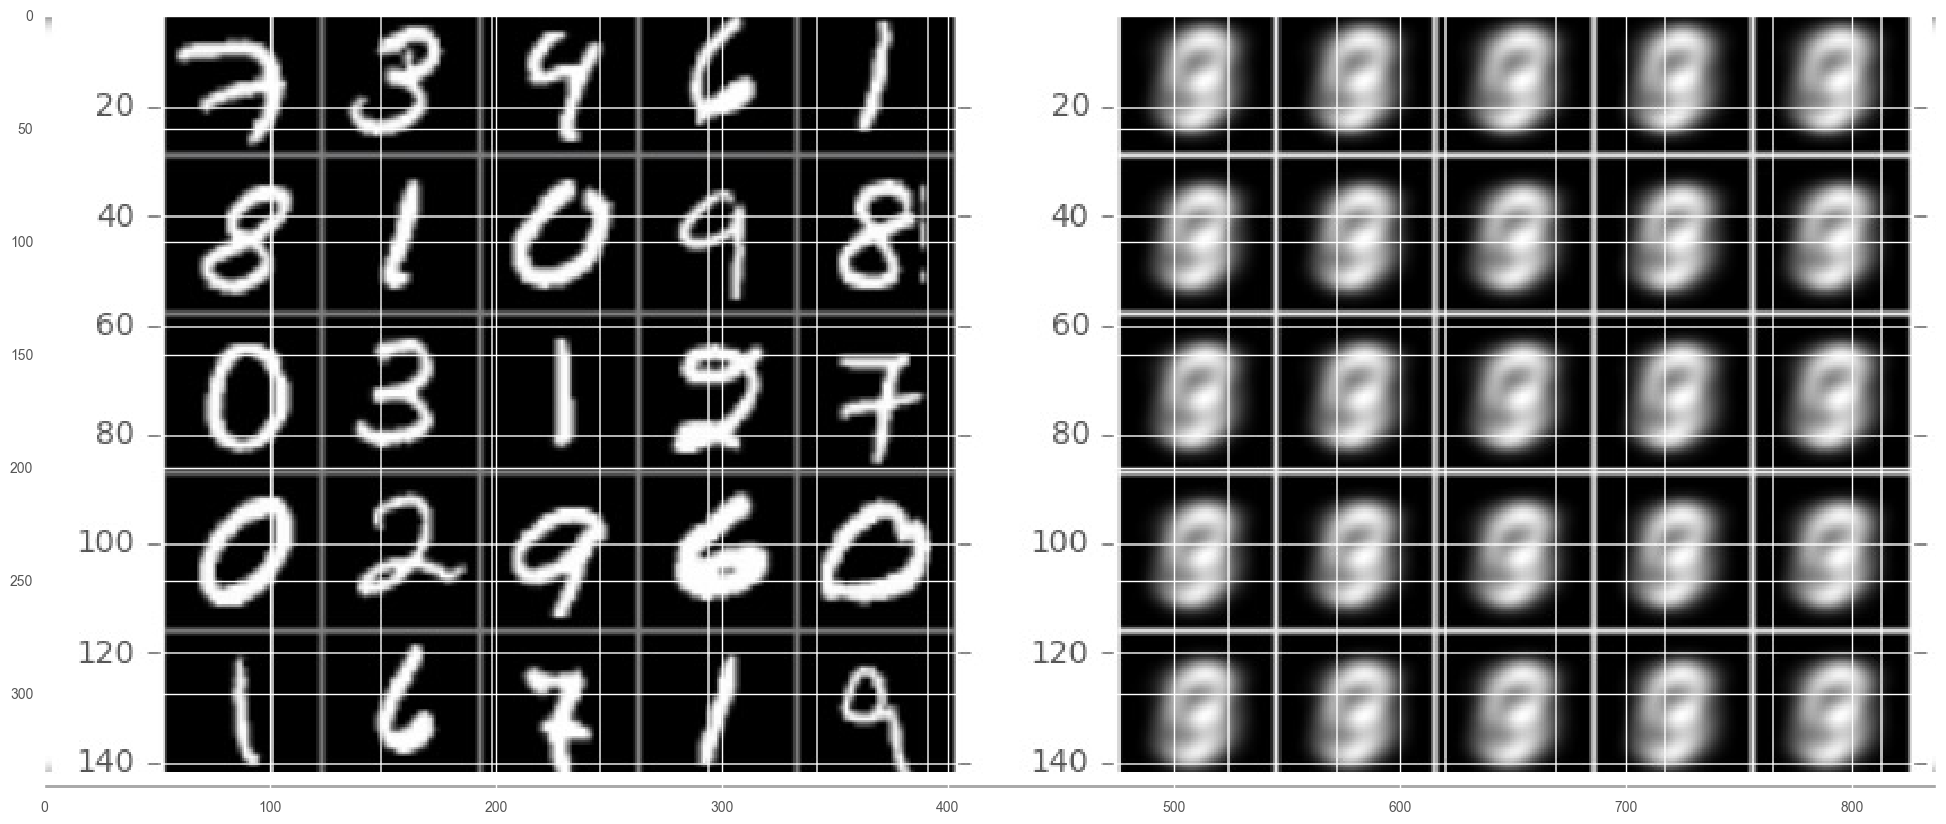

In [214]:
print_img_from_clipboard()